In [3]:
# 평가문항	상세기준
# 1. 자기만의 카메라앱 기능 구현을 완수하였다.	얼굴 영역과 랜드마크를 정확하게 검출하고, 스티커 사진을 합성시키는 데 성공하였다.
# 2. 스티커 이미지를 정확한 원본 위치에 반영하였다.	정확한 좌표계산을 통해 고양이 수염의 위치가 원본 얼굴에 잘 어울리게 출력되었다.
# 3. 카메라 스티커앱을 다양한 원본이미지에 적용했을 때의 문제점을 체계적으로 분석하였다.	얼굴각도, 이미지 밝기, 촬영거리 등 다양한 변수에 따른 영향도를 보고서에 체계적으로 분석하였다.

In [6]:
!pwd

/aiffel/aiffel


In [335]:
import os 
import cv2 
import matplotlib.pyplot as plt 
import numpy as np 
import dlib
import math

In [ ]:
my_image_path = '/aiffel/aiffel/camera_sticker/images/IMG.png' 
img_bgr = cv2.imread(my_image_path)   
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_show = img_rgb.copy()  # 출력용 이미지를 따로 보관
plt.imshow(img_show) 
plt.show() 

In [357]:
def face_detector(imgpath, npyramid, show=True):
    
    img_bgr = cv2.imread(imgpath)   
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    detector_hog = dlib.get_frontal_face_detector() 
    dlib_rects = detector_hog(img_rgb, npyramid) 
    print(dlib_rects)   
    
    for dlib_rect in dlib_rects: # coordinates
        l,t,r,b = dlib_rect.left(), dlib_rect.top(), dlib_rect.right(), dlib_rect.bottom()

        cv2.rectangle(img_rgb, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림
    if show:
        plt.imshow(img_rgb)
        plt.show()
    return dlib_rects
dlib_rects = face_detector(my_image_path, 3, False)

rectangles[[(287, 165) (426, 304)]]


68


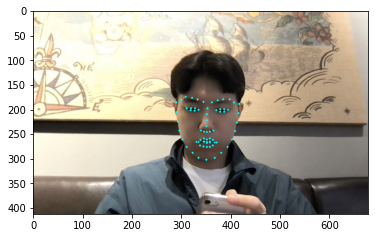

In [338]:
def keypoint_estimation(dlib_rects, model_path, show=True):
    landmark_predictor = dlib.shape_predictor(model_path)
    list_landmarks = []
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_rgb, dlib_rect) # 모든 landmark의 위치정보를 points 변수에 저
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))    # 각각의 landmark 위치정보를 (x,y) 형태로 변환하여 list_points 리스트로 저장
        list_landmarks.append(list_points) 
    print(len(list_landmarks[0]))
    
    for landmark in list_landmarks:
        for point in landmark:
            cv2.circle(img_rgb, point, 2, (0, 255, 255), -1)# 크기가 2이고 (0, 255, 255)색, thikness)
    if show:
        plt.imshow(img_rgb)
        plt.show()
    return list_landmarks
    
model_path = '/aiffel/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
list_landmarks  = keypoint_estimation(dlib_rects, model_path)

(352, 246)


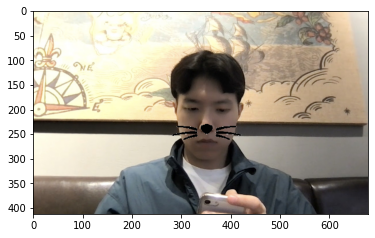

In [339]:
from typing import List
# List[str]
def get_sticker(sticker_path, dlib_rects, list_landmarks):

    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
        print (landmark[30]) 
        x = landmark[30][0]
        y = landmark[30][1]
        w = h = dlib_rect.width() 

    img_sticker = cv2.imread(sticker_path) 
    #스티커 이미지 조정 → w,h는 얼굴 영역의 가로를 차지하는 픽셀의 수(187) // cv2.resize(image객체 행렬, (가로 길이, 세로 길이))
    img_sticker = cv2.resize(img_sticker, (w,h)) 

    #얼굴에 맞춰 부붙이기 위해 조정 (스티커를 붙일 시작점)
    refined_x = x - w // 2
    refined_y = y - h // 2

    #스티커가 붙을 영역을 추출
    # img_sticker.shape[0]: 스티커의 세로 
    # img_sticker.shape[1]: 스티커의 가로
    # 스티커를 붙일 영역을 추출
    sticker_area = img_show[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x + img_sticker.shape[1]]
    
    #np.where(img_sticker == 255, sticker_area, img_sticker): 이미지에서 흰색 부분만 원본 이미지에서 추출한 sticker_area로 덮음.
    img_show[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x + img_sticker.shape[1]] = \
        np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

    plt.imshow(img_show)
    plt.show()

sticker_path = '/aiffel/aiffel/camera_sticker/images/cat-whiskers.png'
get_sticker(sticker_path, dlib_rects,list_landmarks )

### Test1: When an angle of the face is tilted

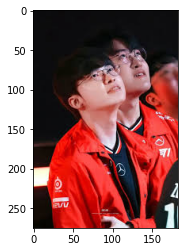

In [346]:
faker_image_path = '/aiffel/aiffel/camera_sticker/images/faker.png' 
img_bgr = cv2.imread(faker_image_path)   
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_show = img_rgb.copy() 
plt.imshow(img_show) 
plt.show() 

rectangles[[(65, 65) (120, 121)]]


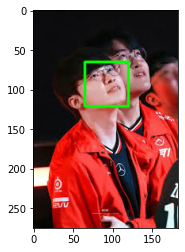

In [347]:
dlib_rects = face_detector(faker_image_path, 3)

68


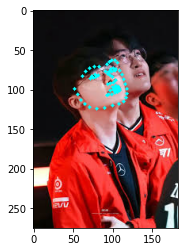

In [344]:
list_landmarks  = keypoint_estimation(dlib_rects, model_path)

(101, 91)


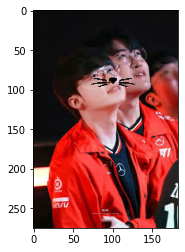

In [345]:
get_sticker(sticker_path, dlib_rects, list_landmarks )

해당 이미지에서는 얼굴 각도가 일정부분 틀어져도 잘 잡아내고 있다.   
하지만 얼굴각도에 맞게 스티커의 각도 변환이 필요해 보인다.

### Angle adjustment is required 

In [359]:
def calc_angle(landmark):
    # 코 위쪽 (27번)과 코 아래쪽 (30번)
    x1, y1 = landmark[27]  # 코 위쪽 
    x2, y2 = landmark[30]  # 코 아래쪽
    
    dy = y2 - y1
    dx = x2 - x1
    angle = math.atan2(dy, dx) * 180 / math.pi  
    return angle


37.874983651098205


위의 앵글로 스티커 붙이기전 rotation 시켜야 한다 (Future work)

### Test2: When the face is partially covered

rectangles[[(241, 57) (380, 196)]]


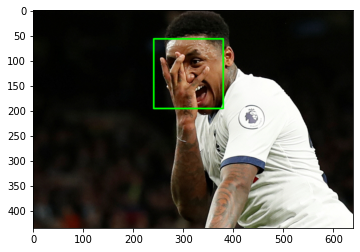

In [271]:
bergwijn_image_path = '/aiffel/aiffel/camera_sticker/images/ver.png' 
dlib_rects = face_detector(bergwijn_image_path, 3)

68


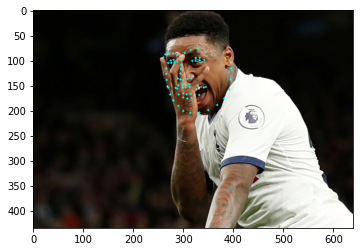

In [272]:
list_landmarks  = keypoint_estimation(dlib_rects, model_path)

(300, 139)


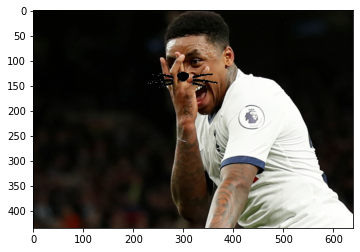

In [273]:
get_sticker(sticker_path, dlib_rects, list_landmarks )

해당 이미지에서는 얼굴이 반정도 가려진 상태에서도, 주요 feautre들을 잘 잡아내는걸 볼 수 있다.

### Test with various images 

rectangles[]


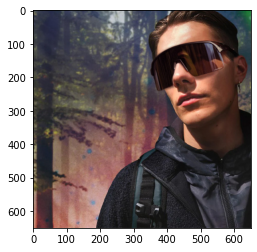

rectangles[]


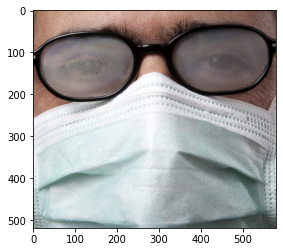

rectangles[[(238, 83) (437, 283)]]


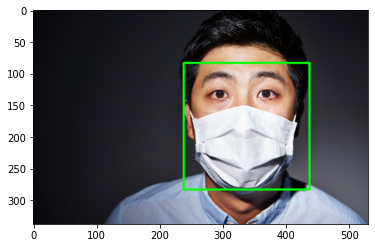

rectangles[[(81, 29) (178, 125)]]


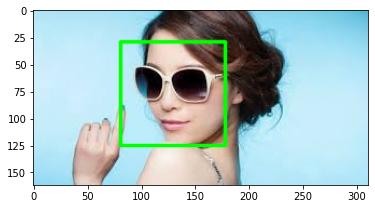

rectangles[[(17, 61) (113, 157)]]


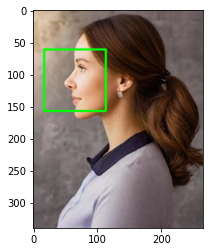

rectangles[[(541, 312) (955, 726)]]


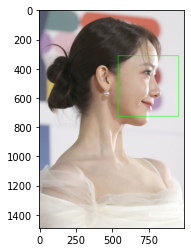

rectangles[[(41, 71) (108, 138)]]


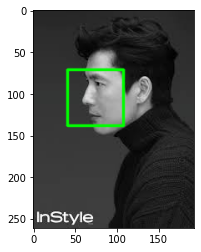

rectangles[]


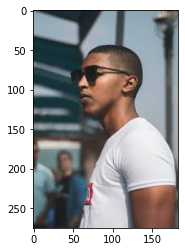

rectangles[]


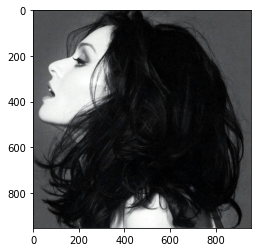

rectangles[[(58, 32) (139, 113)]]


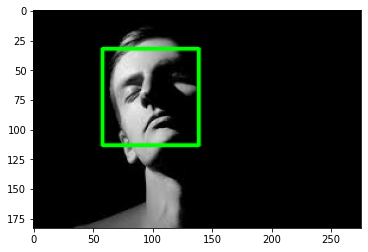

rectangles[[(279, 216) (567, 504)]]


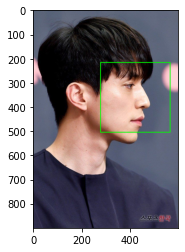

rectangles[]


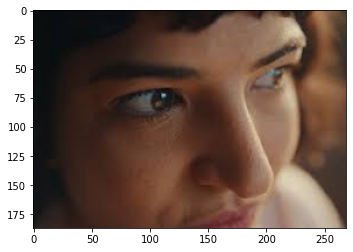

rectangles[[(87, 152) (375, 440)]]


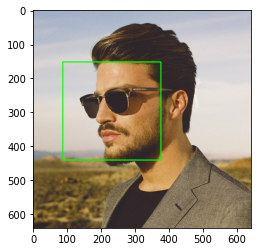

rectangles[[(35, 174) (449, 588)]]


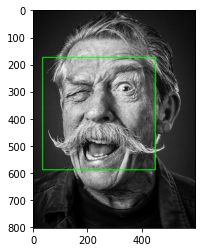

rectangles[[(104, 83) (304, 283)]]


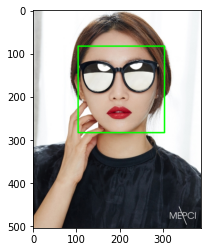

rectangles[[(105, 124) (271, 291)]]


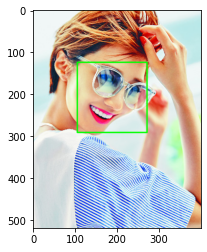

rectangles[[(1121, 483) (1168, 529)], [(817, 189) (932, 304)], [(522, 166) (602, 246)]]


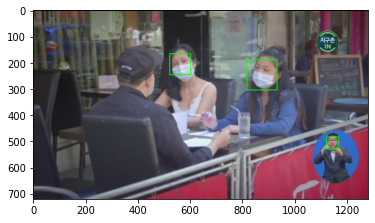

rectangles[]


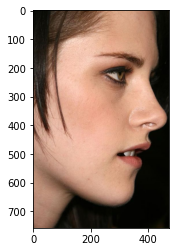

rectangles[[(297, 68) (642, 413)], [(220, 238) (259, 277)]]


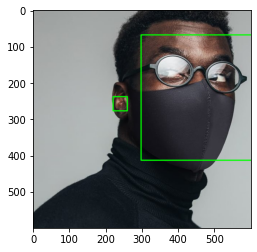

In [360]:
import os

def iterate_sunglass_img(folder_path):
    res_list = []
    for file_name in os.listdir(folder_path):  
        file_path = os.path.join(folder_path, file_name)  
        dlib_rects = face_detector(file_path, 3)
        a = True if dlib_rects else False
        res_list.append(a)
    return res_list

base_dir = "/aiffel/aiffel/camera_sticker/images/Untitled Folder"  
res = iterate_sunglass_img(base_dir)

위 다양한 이미지를 입력해가면서 확인해보려고 하였던 내용  
먼저 dlib자체가 성능이 좋은 모델이 아니기 때문에, 바운딩 박스의 범위가 잘 안쳐지는것같다.
극소량의 수집 데이터로 일관된 결과가 나오지 않았으며, 대략의 결과 파악도 어렵다.

- 1. 선글라스(눈),마스크(입)등 안면의 일부가 가겨진 이미지(9장)에 대한 테스트
- 2. 측면 이미지 (4장)에 대한 테스트 
- 3. GreyScale 이미지(4장)에 대한 테스트
- 4. 얼굴이 가득찬 이미지 (2장)에 대한 테스트
- 5. 동(8장)/서양(11장)에 대한 테스트